# V1.3
**Avtor:** Viktor Rackov

In [7]:
import os, numpy as np, matplotlib.pyplot as plt
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

NUM_WORDS = 3000
VAL_SPLIT = 10000
EPOCHS = 30
BATCH_SIZE = 512
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print(tf.__version__)


2.20.0


## Nalaganje in vektorizacija (multi-hot, top 3000)


In [8]:
def vectorize_sequences(sequences, dimension=NUM_WORDS):
    result = np.zeros((len(sequences), dimension), dtype="float32")
    for i, seq in enumerate(sequences):
        idx = np.unique([w for w in seq if 0 <= w < dimension])
        result[i, idx] = 1.0
    return result

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)
x_train_vec = vectorize_sequences(x_train, NUM_WORDS)
x_test_vec  = vectorize_sequences(x_test, NUM_WORDS)
x_train_vec.shape, x_test_vec.shape


((25000, 3000), (25000, 3000))

## Model s 4 nevroni v skritih plasteh


In [9]:
x_val, y_val = x_train_vec[:VAL_SPLIT], y_train[:VAL_SPLIT]
partial_x_train, partial_y_train = x_train_vec[VAL_SPLIT:], y_train[VAL_SPLIT:]

model = keras.Sequential([
    keras.Input(shape=(NUM_WORDS,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,799,681 (6.87 MB)

 Trainable params: 1,799,681 (6.87 MB)

 Non-trainable params: 0 (0.00 B)

## Učenje


In [10]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    partial_x_train, partial_y_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    verbose=2
)


Epoch 1/30
30/30 - 1s - 27ms/step - accuracy: 0.7982 - loss: 0.4284 - val_accuracy: 0.8729 - val_loss: 0.3108
Epoch 2/30
30/30 - 0s - 13ms/step - accuracy: 0.9185 - loss: 0.2088 - val_accuracy: 0.8794 - val_loss: 0.3231
Epoch 3/30
30/30 - 0s - 13ms/step - accuracy: 0.9412 - loss: 0.1491 - val_accuracy: 0.8641 - val_loss: 0.3922
Epoch 4/30
30/30 - 0s - 13ms/step - accuracy: 0.9744 - loss: 0.0764 - val_accuracy: 0.8198 - val_loss: 0.6205
Epoch 5/30
30/30 - 0s - 13ms/step - accuracy: 0.9560 - loss: 0.1032 - val_accuracy: 0.8559 - val_loss: 0.4353
Epoch 6/30
30/30 - 0s - 13ms/step - accuracy: 0.9738 - loss: 0.0692 - val_accuracy: 0.8679 - val_loss: 0.4410
Epoch 7/30
30/30 - 0s - 14ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.8763 - val_loss: 0.5026
Epoch 8/30
30/30 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8755 - val_loss: 0.5455
Epoch 9/30
30/30 - 0s - 12ms/step - accuracy: 1.0000 - loss: 8.5743e-04 - val_accuracy: 0.8772 - val_loss: 0.5778
Epoch 

## Grafi izgube in točnosti


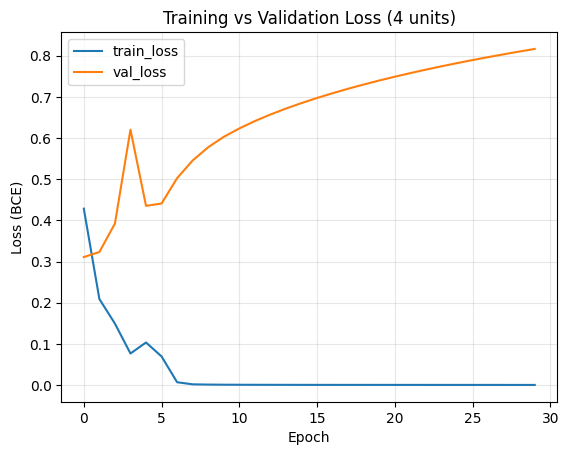

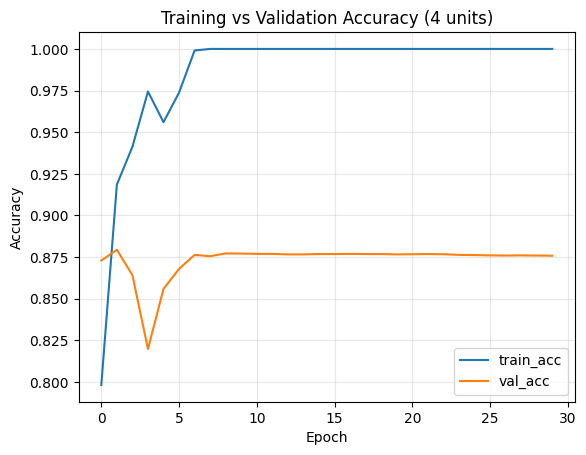

In [11]:
hist = history.history
# Loss
plt.figure()
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss (BCE)'); plt.title('Training vs Validation Loss (4 units)')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Accuracy
plt.figure()
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training vs Validation Accuracy (4 units)')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


## Detekcija prekomernega prileganja in testna ocena


In [12]:
val_loss = np.array(hist['val_loss'], dtype=float)
loss = np.array(hist['loss'], dtype=float)

best_epoch = int(np.argmin(val_loss)) + 1
start_epoch = None
for i in range(1, len(val_loss)):
    if (val_loss[i] > val_loss[i-1]) and (loss[i] < loss[i-1]):
        start_epoch = i + 1
        break

print(f"Najboljši epoch po val_loss: {best_epoch}")
if start_epoch is not None:
    print(f"Prekomerno prileganje se začne približno pri epohi: {start_epoch}")
else:
    print("Jasnega začetka prekomernega prileganja v znotraj treniranih epoh ni.")

test_loss, test_acc = model.evaluate(x_test_vec, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}")


Najboljši epoch po val_loss: 1
Prekomerno prileganje se začne približno pri epohi: 2
Test — loss: 0.8425, acc: 0.8678


With 512 neurons, the training becomes much more computationally expensive, and the network adapts faster but less smoothly during training. Training acc goes to 100%!
The larger capacity also leads to clear overfitting, as the model quickly memorizes the training data while validation performance stops improving.